In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt

## 1. Data

Here we load data from pickle files:
1. Data_train: list, 6000, contains the names of tiles that are used to train the model
2. Data_val: list, 1500, contains the names of tiles that are used to validate the model
3. Data_pair: dict, 7500, keys are the names of tiles, the corresponding value of each key is the roads the tile conatins
4. dict_tile_label_true: dict, 7500, keys are the names of tiles, the corresponding value of each key is the roads the tile contains
4. Define the folder of images

In [103]:
int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W',  5:'M'}
dict_roadtype = {
    "G": 'Municipality',
    "R": 'Government',
    "P": 'Province',
    "W": 'Water management authorities',
    'T': 'Other type',
    "M": 'Multi types',
    "": 'No road',
    "0": 'No road'
}
upsample_scale = {0: 1, 1:1, 2:30, 3:60, 4:1, 5:1}

In [3]:
import pickle

with open('../data/data_train.pkl', 'rb') as f:
     data_train = pickle.load(f)
        
with open('../data/data_val.pkl', 'rb') as f:
    data_val = pickle.load(f)

with open('../data/data_pair.pkl', 'rb') as f:
    data_pair = pickle.load(f)

# with open('../data/dict_tile_label_true.pkl', 'rb') as f:
#     data_tile_label = pickle.load(f)
    
FOLDER_IMG = '../datasets/image_tiles_200/'

Upsampling R and P type images

In [4]:
def classify_roads(data, data_pair):
    d_tile_imgs = defaultdict(list)
    for img in data:
        d_tile_imgs[data_pair[img]].append(img)
    return d_tile_imgs

In [5]:
d_tile_imgs_train = classify_roads(data_train, data_pair)
for k in sorted(d_tile_imgs_train.keys()):
    print('{}, {}, {}'.format(int2rtype[k], dict_roadtype[int2rtype[k]], len(d_tile_imgs_train[k])))

0, No road, 2044
G, Municipality, 2544
P, Province, 92
R, Goverment, 53
W, Water managerment authorities, 694
M, Multi types, 573


In [6]:
d_tile_imgs_val = classify_roads(data_val, data_pair)
for k in sorted(d_tile_imgs_val.keys()):
    print('{}, {}, {}'.format(int2rtype[k], dict_roadtype[int2rtype[k]], len(d_tile_imgs_val[k])))

0, No road, 509
G, Municipality, 630
P, Province, 21
R, Goverment, 17
W, Water managerment authorities, 169
M, Multi types, 154


In [6]:
def upsample(d_tile_imgs, upsample_scale):
    data = []
    for k in d_tile_imgs.keys():
        data += d_tile_imgs[k]*upsample_scale[k]
    return data

In [10]:
upsample_scale = {0: 1, 1:1, 2:20, 3:30, 4:3, 5:3}
data_train = upsample(d_tile_imgs_train, upsample_scale)
a = classify_roads(data_train, data_pair)
for k in sorted(a.keys()):
    print('{}, {}, {}'.format(int2rtype[k], dict_roadtype[int2rtype[k]], len(a[k])))

0, No road, 2044
G, Municipality, 2544
P, Province, 1840
R, Goverment, 1590
W, Water managerment authorities, 2082
M, Multi types, 1719


## Create Dataset

Here we define our dataset class:
1. The inputs of the class are: image folder, data (tile names), pair (tile names: label)
2. The class return indexed tuples: (tensor, label)



In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import random

In [12]:
class Insight_Dataset(Dataset):
    """
    The size of image is (3, 256, 256)
    """
    def __init__(self, img_folder, data, pair):
        self.folder = img_folder
        self.data = data
        #self.keys = list(d_tile_label.keys()).sort(key=lambda x: [int(x.split('_')[0]), int(x.split('_')[1])])
        self.pair = pair
        self.colorjitter = transforms.ColorJitter()
    
    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        '''
        return （image, label）
        '''
        tile_name = self.folder + self.data[idx]
        img = plt.imread(tile_name)
        label = self.pair[self.data[idx]]
        k = random.randint(0,9)
        if k==0:
            img = img.transpose(1,0,2)
        elif k==1:
            img = img.transpose(1,0,2)
            img = img.transpose(1,0,2)
        elif k==2:
            img = img.transpose(1,0,2)
            img = img.transpose(1,0,2)
            img = img.transpose(1,0,2)
        else:
            img = self.colorjitter(img)
        return (torch.FloatTensor(img.T), label)


## Design the model

VGG16 except the stride size of the first layer by changing it from (1,1) to (2,2)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        """
        1. VGG16
        
        """
        self.conv1 = nn.Conv2d(3, 64 , (3, 3), stride=(2, 2), padding=1)
        self.conv2 = nn.Conv2d(64, 64 , (3, 3), stride=(1, 1), padding=1)
        
        self.conv3 = nn.Conv2d(64, 128 , (3, 3), stride=(1, 1), padding=1)
        self.conv4 = nn.Conv2d(128, 128 , (3, 3), stride=(1, 1), padding=1)
        
        self.conv5 = nn.Conv2d(128, 256 , (3, 3), stride=(1, 1), padding=1)
        self.conv6 = nn.Conv2d(256, 256 , (3, 3), stride=(1, 1), padding=1)
        self.conv7 = nn.Conv2d(256, 256 , (3, 3), stride=(1, 1), padding=1)
        
        self.conv8 = nn.Conv2d(256, 512 , (3, 3), stride=(1, 1), padding=1)
        self.conv9 = nn.Conv2d(512, 512 , (3, 3), stride=(1, 1), padding=1)
        self.conv10 = nn.Conv2d(512, 512 , (3, 3), stride=(1, 1), padding=1)
        
        self.conv11 = nn.Conv2d(512, 512 , (3, 3), stride=(1, 1), padding=1)
        self.conv12 = nn.Conv2d(512, 512 , (3, 3), stride=(1, 1), padding=1)
        self.conv13 = nn.Conv2d(512, 512 , (3, 3), stride=(1, 1), padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2,2), stride = (2,2))
        self.linear = nn.Linear(512*4*4, 6)
        
       
        
    def forward(self, img):
        hidden = self.relu(self.conv1(img))
        hidden = self.relu(self.conv2(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv3(hidden))
        hidden = self.relu(self.conv4(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv5(hidden))
        hidden = self.relu(self.conv6(hidden))
        hidden = self.relu(self.conv7(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv8(hidden))
        hidden = self.relu(self.conv9(hidden))
        hidden = self.relu(self.conv10(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv11(hidden))
        hidden = self.relu(self.conv12(hidden))
        hidden = self.relu(self.conv13(hidden))
        hidden = self.maxpool(hidden)
        
        out = hidden.view(hidden.size(0), -1)
        out = self.linear(out)
        
        return out 

# Training the model

1. Use DataLoader to batchize the train dataset
2. Define test_model function, which evaluate model and return the accuracy and loss
3. Build and train the CNN model: 
     1. Define the hyperparameters: learning rate, epoch numbers
     2. Use cross entropy as the loss function
     3. Use Adam as the optimizer
     4. Build the model
     5. In each epoch, evaluate the model once, and save the model with best performance
4. Save the result: training and validation accuracy (and loss)   

In [22]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    total_loss = 0
    criterion_test = nn.CrossEntropyLoss()
    model.eval()
    torch.no_grad()
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device),  labels.to(device)
        outputs = model(imgs)
        
        loss_test = float(criterion_test(outputs, labels))
        total_loss += loss_test       
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss/len(loader)

In [14]:
BATCH_SIZE = 32
VALIDATE_STEP = 180

model_name = '../models/VGG16_week3_upsample.pt'
result_FILE = '../results/VGG16_week3_upsample.pkl'

learning_rate = 1e-5*2
num_epochs = 20 # number epoch to train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
upsample_scale = {0: 1, 1:1, 2:30, 3:30, 4:3, 5:1}
WEIGHT = [1, 1, 2, 2, 1, 1]

data_train = upsample(d_tile_imgs_train, upsample_scale)
a = classify_roads(data_train, data_pair)
for k in sorted(a.keys()):
    print('{}, {}, {}'.format(int2rtype[k], dict_roadtype[int2rtype[k]], len(a[k])))
    
train_data = Insight_Dataset(FOLDER_IMG, data_train, data_pair)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_data = Insight_Dataset(FOLDER_IMG, data_val, data_pair)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)

0, No road, 2044
G, Municipality, 2544
P, Province, 2760
R, Goverment, 1590
W, Water managerment authorities, 2082
M, Multi types, 573


In [51]:
len(train_data)//BATCH_SIZE

362

In [52]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3, 3), s

In [54]:
best_val_acc = 0

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss(torch.FloatTensor(WEIGHT).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_record = []
train_acc_record = []
val_loss_record = []
train_loss_record = []
step_record = []

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(imgs.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i >0 and i % VALIDATE_STEP == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_record.append(val_acc)
            val_loss_record.append(val_loss)
            train_acc, train_loss = test_model(train_loader, model)
            train_acc_record.append(train_acc)
            train_loss_record.append(train_loss)
            step_record.append(i + epoch*total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Train Acc: {}, Val Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_loss, train_acc, val_acc))
#             print('Epoch: [{}/{}], Step: [{}/{}], Val Acc: {}'.format(
#                        epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            if val_acc > best_val_acc:
                with open(model_name, 'wb') as f:
                    torch.save(model, f)
                    best_val_loss = val_loss

# training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
# pkl.dump(training_curve, open(result_FILE, "wb"))

Epoch: [1/20], Step: [181/363], Train Loss: 1.7398241140954094, Train Acc: 23.807470025015096, Val Acc: 1.4
Epoch: [1/20], Step: [361/363], Train Loss: 1.7433574564200787, Train Acc: 23.807470025015096, Val Acc: 1.4
Epoch: [2/20], Step: [181/363], Train Loss: 1.4920687544115976, Train Acc: 39.26507375140171, Val Acc: 25.933333333333334
Epoch: [2/20], Step: [361/363], Train Loss: 1.328403784880625, Train Acc: 46.45044423358924, Val Acc: 32.266666666666666
Epoch: [3/20], Step: [181/363], Train Loss: 1.2404035390572772, Train Acc: 54.757181057534716, Val Acc: 44.8
Epoch: [3/20], Step: [361/363], Train Loss: 1.1925149474590606, Train Acc: 56.784266367635645, Val Acc: 47.6
Epoch: [4/20], Step: [181/363], Train Loss: 1.0633354054009618, Train Acc: 60.88156646252049, Val Acc: 48.333333333333336
Epoch: [4/20], Step: [361/363], Train Loss: 1.0075252757256352, Train Acc: 62.95178124730441, Val Acc: 54.333333333333336
Epoch: [5/20], Step: [181/363], Train Loss: 0.934266831264023, Train Acc: 65.66

In [118]:
training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
pickle.dump(training_curve, open(result_FILE, "wb"))

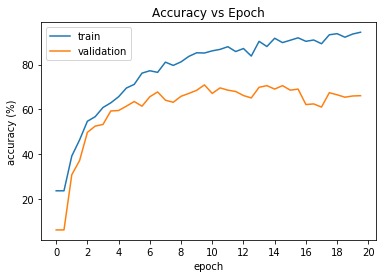

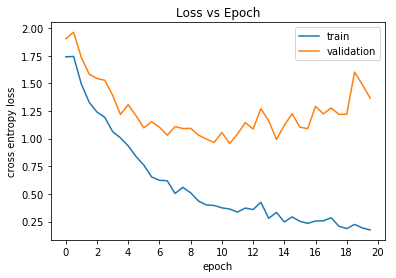

In [120]:
x = [k/2 for k in range(len(train_acc_record))]
x_in = [2*k for k in range(11)]

plt.plot(x, train_acc_record, label = 'train')
plt.plot(x, val_acc_record_up, label = 'validation')
plt.xticks(x_in)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.savefig('../results/week2/accuracy_curve_upsampling.jpg')
plt.show()

plt.plot(x, train_loss_record, label = 'train')
plt.plot(x, val_loss_record_up, label = 'validation')
plt.xticks(x_in)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Loss vs Epoch')
plt.savefig('../results/week2/loss_curve_upsampling.jpg')
plt.show()

# Analyze Result

In [57]:
val_data = Insight_Dataset(FOLDER_IMG, data_val, data_pair)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                        batch_size = 1,
                                        shuffle = False)

In [58]:
#model = torch.load('../models/VGG16.pt')
model =  torch.load('../models/VGG16_week3_upsample.pt')

In [59]:
correct = defaultdict(int)
fault = defaultdict(list)
total = defaultdict(int)
total_loss = defaultdict(int)

model.eval()
torch.no_grad()

true_label = []
pre_label = []

for i, (img, label) in enumerate(val_loader):
    img = img.to(device)
    outputs = model(img)

    #loss_test = float(criterion_test(outputs, labels))
    #total_loss += loss_test       
    outputs = F.softmax(outputs, dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    pred = np.asarray(predicted)[0][0]
    label = np.asarray(label)[0]
    true_label.append(label)
    pre_label.append(pred)
    if pred==label:
        correct[label] += 1
    else:
        fault[label].append([i, pred])
    total[label]+= 1

    #total += labels.size(0)
    #correct += predicted.eq(labels.view_as(predicted)).sum().item()

In [60]:
accuracy = defaultdict(float)
for k in total.keys():
    accuracy[k] = correct[k]/total[k]
accuracy

defaultdict(float,
            {1: 0.7841269841269841,
             4: 0.4260355029585799,
             0: 0.6110019646365422,
             5: 0.24025974025974026,
             3: 0.11764705882352941,
             2: 0.5238095238095238})

In [104]:
int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W',  5:'M'}
dict_roadtype = {
    "G": 'Municipality',
    "R": 'Government',
    "P": 'Province',
    "W": 'Water management authorities',
    'T': 'Other type',
    "M": 'Multi types',
    "": 'No road',
    "0": 'No road'
}

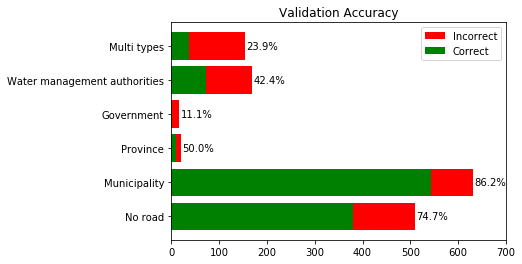

In [105]:
#int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W', 5:'T', 6:'M'}
x = sorted(list(int2rtype.keys()))
total_cnt = [total[k] for k in x]
correct_cnt = [correct[k] for k in x]
x_label = [int2rtype[k] for k in x]
x_label1 = [dict_roadtype[k] for k in x_label]

ax = plt.subplot(111)
#bar = ax.bar(x, total_cnt, width=0.6, color='r', align='center', label = 'Incorrect')
ax.barh(x, total_cnt, color='r', align='center', label = 'Incorrect')
ax.barh(x, correct_cnt, color='g', align='center', label = 'Correct')
#ax.bar(x+0.2, k, width=0.2, color='r', align='center')

# plt.bar(x, y2)
# plt.bar(x, y)
#plt.xticks(x,x_label,rotation=40)
plt.yticks(x,x_label1,rotation=0)
x_in = [100*k for k in range(8)]
plt.xticks(x_in)

for i, v in enumerate(total_cnt):
    ax.text(v + 3, i, '{:.1f}%'.format(100*correct_cnt[i]/(total_cnt[i]+1)), va='center')
# for i, rect in enumerate(bar):
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2.0, height, '{:.1f}%'.format(100*correct_cnt[i]/(total_cnt[i]+1)), ha='center', va='bottom')
    
plt.legend()
# plt.xlabel('Road Type')
# plt.ylabel('count')
plt.title('Validation Accuracy')
plt.savefig('../results/week2/val_acc_upsampling.jpg', dpi=500, bbox_inches = "tight")
plt.show()

In [101]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots()
    plt.figure(figsize=(150,150))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if normalize:
        fig.savefig('../results/week2/VGG16_confusion_matrix_wn_upsample.jpg', dpi=300, bbox_inches = "tight")
    else:
        fig.savefig('../results/week2/VGG16_confusion_matrix_upsample.jpg', dpi=300, bbox_inches = "tight")
    plt.show()
    return ax

Normalized confusion matrix
[[ 0.74066798  0.08840864  0.00392927  0.          0.1453831   0.021611  ]
 [ 0.03968254  0.85873016  0.00634921  0.          0.03650794  0.05873016]
 [ 0.0952381   0.14285714  0.52380952  0.          0.19047619  0.04761905]
 [ 0.          0.64705882  0.          0.11764706  0.          0.23529412]
 [ 0.26627219  0.20710059  0.01775148  0.00591716  0.4260355   0.07692308]
 [ 0.02597403  0.56493506  0.03246753  0.00649351  0.12987013  0.24025974]]


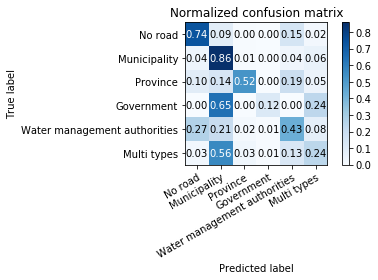

In [106]:
plot_confusion_matrix(true_label, pre_label, classes=x_label1, normalize=True)
plt.show()